In [ ]:
import numpy as np 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Function to convert grayscale to RGB and assign colors
def colored_mnist(dataset):
    colored_data = []
    colored_labels = []
    # Define a color palette for digits 0-9
    colors = [
        [1, 0, 0],    # Red
        [0, 1, 0],    # Green
        [0, 0, 1],    # Blue
        [1, 1, 0],    # Yellow
        [1, 0, 1],    # Magenta
        [0, 1, 1],    # Cyan
        [0.5, 0.5, 0],# Olive
        [0.5, 0, 0.5],# Purple
        [0, 0.5, 0.5],# Teal
        [0.5, 0.5, 0.5] # Gray
    ]
    
    for img, label in dataset:
        img = img.squeeze(0)  # Remove channel dimension
        colored_img = torch.stack([img * colors[label][0],
                                   img * colors[label][1],
                                   img * colors[label][2]], dim=0)
        colored_data.append(colored_img)
        colored_labels.append(label)
        
    return torch.stack(colored_data), torch.tensor(colored_labels)

# Apply to training and test datasets
train_data, train_labels = colored_mnist(train_dataset)
test_data, test_labels = colored_mnist(test_dataset)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 9912422/9912422 [00:05<00:00, 1890209.65it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 28881/28881 [00:00<00:00, 125897.65it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 1648877/1648877 [00:03<00:00, 461144.43it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 4542/4542 [00:00<00:00, 4539082.38it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Train data shape: torch.Size([60000, 3, 28, 28])
Test data shape: torch.Size([10000, 3, 28, 28])


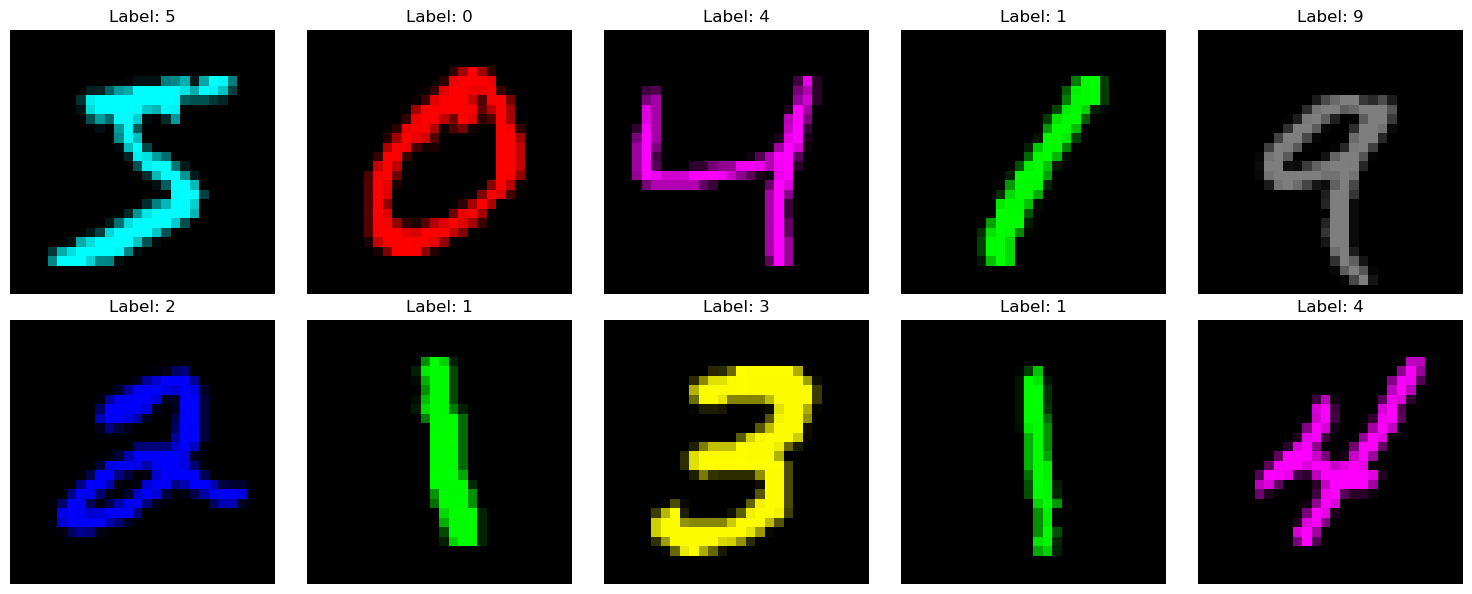

In [2]:
# Plot some samples
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(train_data[i].permute(1, 2, 0).numpy())
    ax.set_title(f"Label: {train_labels[i].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()


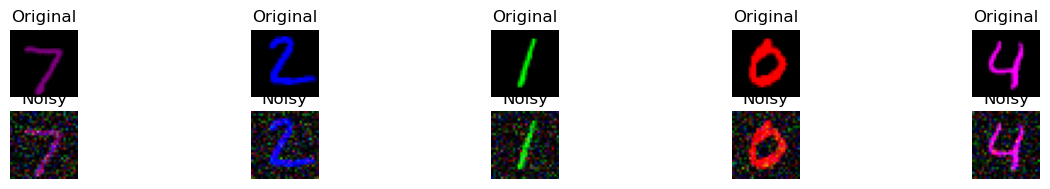

In [3]:
def add_gaussian_noise(images, sigma=0.1):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

# Add noise to training and test data
sigma = 0.2  # Adjust noise level as needed
train_noisy = add_gaussian_noise(train_data, sigma)
test_noisy = add_gaussian_noise(test_data, sigma)

# Visualize some examples
def show_images(original, noisy, denoised=None, num=5):
    plt.figure(figsize=(15, 3))
    for i in range(num):
        # Original
        ax = plt.subplot(3, num, i + 1)
        plt.imshow(original[i].permute(1, 2, 0).numpy())
        plt.title("Original")
        plt.axis('off')
        
        # Noisy
        ax = plt.subplot(3, num, i + 1 + num)
        plt.imshow(noisy[i].permute(1, 2, 0).numpy())
        plt.title("Noisy")
        plt.axis('off')
        
        # Denoised (if provided)
        if denoised is not None:
            ax = plt.subplot(3, num, i + 1 + 2*num)
            plt.imshow(denoised[i].permute(1, 2, 0).detach().cpu().numpy())
            plt.title("Denoised")
            plt.axis('off')
    plt.show()

# Initially, denoised is None
show_images(test_data, test_noisy)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),  # [128,14,14]
            nn.ReLU(True),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1), # [64,7,7]
            nn.ReLU(True),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),  # [32,4,4]
            nn.ReLU(True),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),  # [16,2,2]
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [32,4,4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64,8,8]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # [128,16,16]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # [3,32,32]
            nn.Sigmoid()  # To ensure output is between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # Interpolate to the original size (28x28)
        x = F.interpolate(x, size=(28, 28), mode='bilinear', align_corners=False)
        return x

# Instantiate the model
model = Autoencoder()
print(model)


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7)

Using device: cuda
Epoch [1/20], Train Loss: 0.047632, Test Loss: 0.042188
Epoch [2/20], Train Loss: 0.041489, Test Loss: 0.042189
Epoch [3/20], Train Loss: 0.041490, Test Loss: 0.042189
Epoch [4/20], Train Loss: 0.028760, Test Loss: 0.015957
Epoch [5/20], Train Loss: 0.011829, Test Loss: 0.008949
Epoch [6/20], Train Loss: 0.007787, Test Loss: 0.006583
Epoch [7/20], Train Loss: 0.006269, Test Loss: 0.005575
Epoch [8/20], Train Loss: 0.005522, Test Loss: 0.005152
Epoch [9/20], Train Loss: 0.005053, Test Loss: 0.004794
Epoch [10/20], Train Loss: 0.004733, Test Loss: 0.004453
Epoch [11/20], Train Loss: 0.004472, Test Loss: 0.004226
Epoch [12/20], Train Loss: 0.004284, Test Loss: 0.004160
Epoch [13/20], Train Loss: 0.004101, Test Loss: 0.003896
Epoch [14/20], Train Loss: 0.003958, Test Loss: 0.003820
Epoch [15/20], Train Loss: 0.003849, Test Loss: 0.003837
Epoch [16/20], Train Loss: 0.003746, Test Loss: 0.003659
Epoch [17/20], Train Loss: 0.003679, Test Loss: 0.003498
Epoch [18/20], Train 

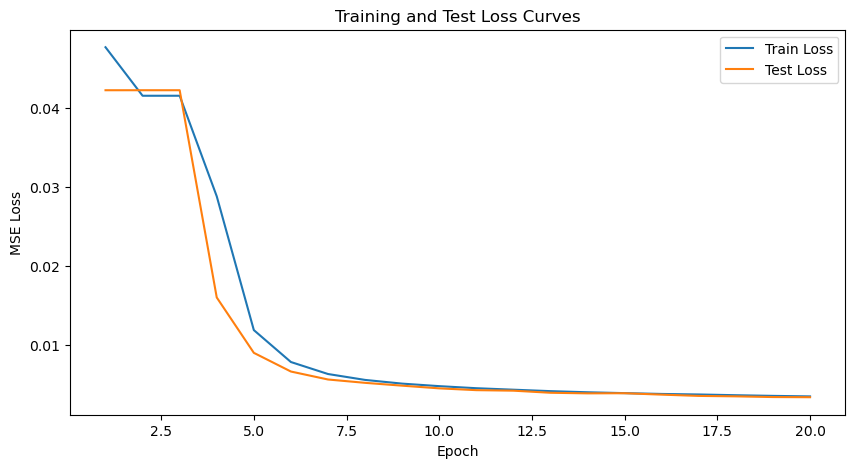

In [6]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move data to device
train_noisy = train_noisy.to(device)
train_data = train_data.to(device)
test_noisy = test_noisy.to(device)
test_data = test_data.to(device)

# Define DataLoader
batch_size = 128
train_loader = DataLoader(torch.utils.data.TensorDataset(train_noisy, train_data), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(test_noisy, test_data), batch_size=batch_size, shuffle=False)

# Move model to device
model = model.to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training parameters
num_epochs = 20
train_losses = []
test_losses = []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Evaluation on test set
    model.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item() * inputs.size(0)
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_losses.append(test_epoch_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.6f}, Test Loss: {test_epoch_loss:.6f}")

# Plot Loss Curves
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()


In [7]:
def calculate_snr(original, denoised):
    # Flatten the images
    original = original.view(original.size(0), -1)
    denoised = denoised.view(denoised.size(0), -1)
    noise = original - denoised
    # Compute power
    signal_power = torch.mean(original ** 2, dim=1)
    noise_power = torch.mean(noise ** 2, dim=1)
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.mean().item()

# Calculate SNR on test set
model.eval()
total_snr = 0.0
total_mse = 0.0
with torch.no_grad():
    for data in test_loader:
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        snr = calculate_snr(targets, outputs)
        total_snr += snr * inputs.size(0)
        mse = criterion(outputs, targets)
        total_mse += mse.item() * inputs.size(0)
avg_snr = total_snr / len(test_loader.dataset)
avg_mse = total_mse / len(test_loader.dataset)

print(f"Average SNR on Test Set: {avg_snr:.2f} dB")
print(f"Average MSE on Test Set: {avg_mse:.6f}")


Average SNR on Test Set: 10.83 dB
Average MSE on Test Set: 0.003331


c:\Users\Pranav\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Pranav\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


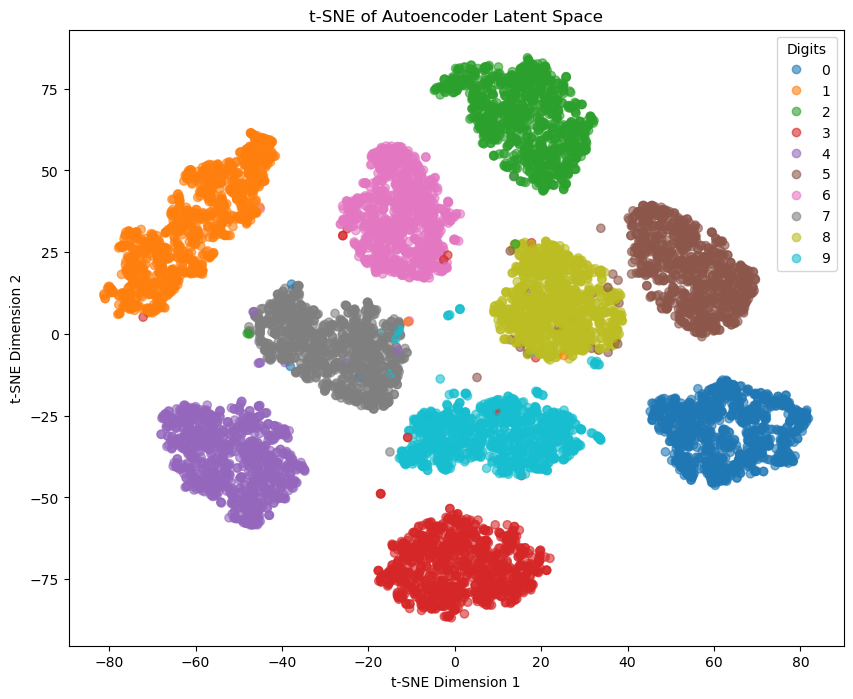

In [11]:
from sklearn.manifold import TSNE

def get_latent_vectors(model, data_loader):
    model.eval()
    latent_vectors = []
    labels_list = []
    with torch.no_grad():
        for data in data_loader:
            inputs, targets, labels = data  # Unpack all three elements
            inputs = inputs.to(device)
            encoded = model.encoder(inputs)
            encoded = encoded.view(encoded.size(0), -1)  # Flatten
            latent_vectors.append(encoded.cpu().numpy())
            labels_list.append(labels.numpy())
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    return latent_vectors, labels_list


# Create a DataLoader with labels
test_loader_with_labels = DataLoader(torch.utils.data.TensorDataset(test_noisy, test_data, test_labels), batch_size=batch_size, shuffle=False)

# Get latent vectors and labels
latent_vectors, labels = get_latent_vectors(model, test_loader_with_labels)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
latent_tsne = tsne.fit_transform(latent_vectors)

# Plot t-SNE
plt.figure(figsize=(10,8))
scatter = plt.scatter(latent_tsne[:,0], latent_tsne[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title('t-SNE of Autoencoder Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [ ]:
# Import optimizer
import torch.optim as optim

class AutoencoderWithDropout(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(AutoencoderWithDropout, self).__init__()
        # Encoder with Dropout
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),  # [128,14,14]
            nn.ReLU(True),
            nn.Dropout(dropout_p),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1), # [64,7,7]
            nn.ReLU(True),
            nn.Dropout(dropout_p),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),  # [32,4,4]
            nn.ReLU(True),
            nn.Dropout(dropout_p),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),  # [16,2,2]
            nn.ReLU(True),
            nn.Dropout(dropout_p)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [32,4,4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64,8,8]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # [128,16,16]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # [3,32,32]
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # Crop to original size
        x = F.interpolate(x, size=(28, 28), mode='bilinear', align_corners=False)
        return x

# Instantiate the model with Dropout
model_dropout = AutoencoderWithDropout(dropout_p=0.2).to(device)

# Define optimizer for the new model
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=1e-3, weight_decay=1e-5)

# Training Loop for the model with Dropout
num_epochs_dropout = 20
train_losses_dropout = []
test_losses_dropout = []

for epoch in range(num_epochs_dropout):
    model_dropout.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Zero gradients
        optimizer_dropout.zero_grad()
        
        # Forward
        outputs = model_dropout(inputs)
        loss = criterion(outputs, targets)
        
        # Backward
        loss.backward()
        optimizer_dropout.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses_dropout.append(epoch_loss)
    
    # Evaluation on test set
    model_dropout.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model_dropout(inputs)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item() * inputs.size(0)
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_losses_dropout.append(test_epoch_loss)
    
    print(f"Dropout Epoch [{epoch+1}/{num_epochs_dropout}], Train Loss: {epoch_loss:.6f}, Test Loss: {test_epoch_loss:.6f}")

# Plot Loss Curves for Dropout Model
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs_dropout+1), train_losses_dropout, label='Train Loss with Dropout')
plt.plot(range(1, num_epochs_dropout+1), test_losses_dropout, label='Test Loss with Dropout')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Curves with Dropout')
plt.legend()
plt.show()


c:\Users\Pranav\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Pranav\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


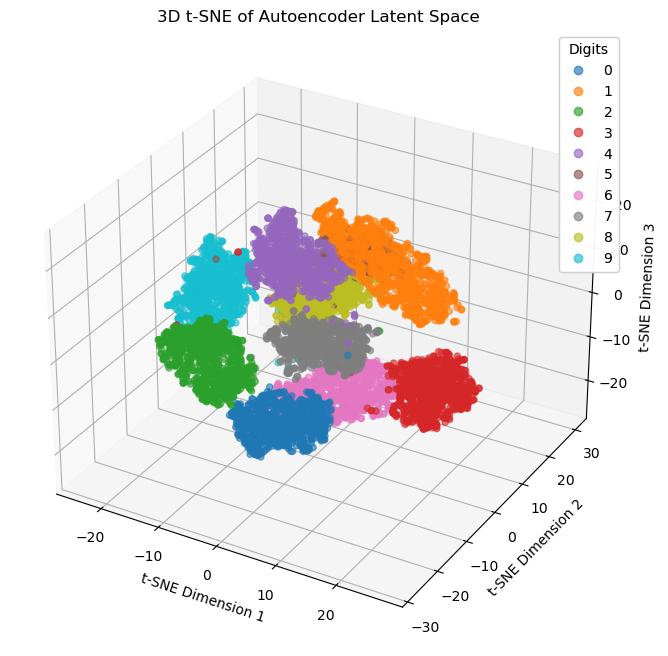

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE with 3 components
tsne_3d = TSNE(n_components=3, random_state=0, perplexity=30, n_iter=1000)
latent_tsne_3d = tsne_3d.fit_transform(latent_vectors)

# Plot 3D t-SNE
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(latent_tsne_3d[:,0], latent_tsne_3d[:,1], latent_tsne_3d[:,2],
                     c=labels, cmap='tab10', alpha=0.6)
legend = ax.legend(*scatter.legend_elements(), title="Digits")
ax.add_artist(legend)
ax.set_title('3D t-SNE of Autoencoder Latent Space')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.show()


In [19]:
import plotly.graph_objs as go
import plotly.io as pio
import numpy as np

# Apply t-SNE with 3 components (already done in your code)
# tsne_3d = TSNE(n_components=3, random_state=0, perplexity=30, n_iter=1000)
# latent_tsne_3d = tsne_3d.fit_transform(latent_vectors)

# Create a scatter plot in Plotly
trace = go.Scatter3d(
    x=latent_tsne_3d[:, 0], 
    y=latent_tsne_3d[:, 1], 
    z=latent_tsne_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=labels,                # Set color to the digit labels
        colorscale='armyrose',        # Colorscale of your choice
        opacity=0.8,
        colorbar=dict(title="Digits") # Shows color legend for digits
    ),
    text=[f"Digit: {label}" for label in labels],  # Hover info
)

# Create layout
layout = go.Layout(
    title="Interactive 3D t-SNE of Autoencoder Latent Space",
    scene=dict(
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        zaxis_title='t-SNE Dimension 3'
    ),
    autosize=True
)

# Create figure and plot
fig = go.Figure(data=[trace], layout=layout)
pio.show(fig)


In [30]:
import plotly.io as pio
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

# Sign in to Plotly
chart_studio.tools.set_credentials_file(username='Assasin1202', api_key='07TFvvwFubUbdl0vydHy')

# Create figure and plot (same as before)
fig = go.Figure(data=[trace], layout=layout)

# Upload plot to Plotly Cloud and get a sharable link
py.plot(fig, filename='tsne_3d_plot', auto_open=True)


PlotlyRequestError: This file is too big! Your current subscription is limited to 524.288 KB uploads. For more information, please visit: https://plotly.com/get-pricing/.

In [34]:
import numpy as np
import plotly.graph_objs as go

# Limit the number of points to reduce plot size
sample_size = 2000  # Reduce this number as needed
indices = np.random.choice(len(latent_vectors), size=sample_size, replace=False)

# Subsample the latent vectors and labels
latent_tsne_sampled = latent_tsne_3d[indices]
labels_sampled = np.array(labels)[indices]

# Create a scatter plot in Plotly
trace = go.Scatter3d(
    x=latent_tsne_sampled[:, 0], 
    y=latent_tsne_sampled[:, 1], 
    z=latent_tsne_sampled[:, 2],
    mode='markers',
    marker=dict(
        size=3,                      # Reduce marker size to save space
        color=labels_sampled,         # Set color to the digit labels
        colorscale='armyrose',        # Use a simple colorscale
        opacity=0.8,
        colorbar=dict(title="Digits")
    ),
    text=[f"Digit: {label}" for label in labels_sampled],  # Hover info
)

# Create layout
layout = go.Layout(
    title="Interactive 3D t-SNE of Autoencoder Latent Space",
    scene=dict(
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        zaxis_title='t-SNE Dimension 3'
    ),
    autosize=True
)

# Create figure and plot
fig = go.Figure(data=[trace], layout=layout)
fig.write_html("tsne_3d_plot.html")
pio.show(fig)
